# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [4]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline, get_linear_schedule_with_warmup

In [5]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [6]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        return class_weights

    def tokenize_text(self, sentences: pd.Series, max_length: int = 256):
        input_ids = []
        attention_masks = []
        total_length = 0
        i = 0
        for sent in tqdm(sentences, desc='Tokenize of sentences'):
            total_length += len(sent)
            i += 1
            encoded = self.tokenizer.encode_plus(
                sent,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask = True,
                return_tensors = 'pt')

            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

    def create_dataloader(self, input_ids, attention_masks, labels, batch_size: int, shuffle: bool = True, pin_mem: bool = False):
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_mem)

    def train_model(self, model, model_name: str, train_dl, dev_dl, criterion, optimizer, scheduler, epochs: int, device):

        # Resize model token embeddings to the len of tokenizer
        model.resize_token_embeddings(len(self.tokenizer))

        # Move model to device
        model.to(device)
        
        true_labels = defaultdict(list)
        predictions = defaultdict(list)
        val_losses = {}
        training_stats = []
        
        best_val_loss = float('inf')
        for i, epoch in enumerate(range(epochs), start=1):
        
            total_train_loss = 0
            model.train()
        
            for batch in tqdm(train_dl, desc=f"Epoch {i}/{epochs}"):
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
        
                model.zero_grad()
        
                result = model(b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels,
                return_dict=True)
        
                logits = result.logits
        
                # Compute weighted loss manually
                loss = criterion(logits, b_labels) # Use weighted loss
                total_train_loss += loss.item()
        
                loss.backward()
        
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
                optimizer.step()
                scheduler.step()
                
            avg_train_loss = total_train_loss / len(train_dl)
        
            model.eval()
        
            total_eval_loss = 0
        
            for batch in tqdm(dev_dl, desc="Evaluating"):
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
        
                with torch.no_grad():
                    result = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels,
                                return_dict=True)
        
                logits = result.logits
        
                loss = criterion(logits, b_labels) # Use weighted loss
                total_eval_loss += loss.item()
        
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
        
                true_labels[i].append(label_ids)
                predictions[i].append(logits)
        
            # Printing the cr
            flat_predictions = np.concatenate(predictions[i], axis=0)
            flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
            flat_true_labels = np.concatenate(true_labels[i], axis=0)
            
            stats = self.evaluate_model(flat_true_labels, flat_predictions)
        
            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(dev_dl)
            val_losses[i] = avg_val_loss
        
            print(f"Epoch {i}/{epochs}\tTrain Loss: {avg_train_loss:.6f}\tVal Loss: {avg_val_loss:.6f}\tL.rate: {optimizer.param_groups[0]['lr']:.6f}\tVal F1: {stats['macro_F1']:.4f}")
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                print("Saving model with new val loss:", best_val_loss)
                torch.save(model.state_dict(), model_name)
        
            training_stats.append(stats)

        print("Loading the best model checkpoint")
        model.load_state_dict(torch.load(model_name, weights_only=True))

        return model

    def test_model(self, model, test_dl, title: str):
        model.eval()
        
        labels = []
        predictions = []
        
        with torch.no_grad():
            for batch in tqdm(test_dl, desc="Predicting"):
                b_input_ids, b_input_mask, b_labels = batch
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_labels = b_labels.to(device)
        
                result = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels,
                                return_dict=True)
        
                logits = result.logits
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
        
                labels.extend(label_ids)
                logits = np.argmax(logits, axis=1)
                predictions.extend(logits)
            
        labels = np.array(labels)
        predictions = np.array(predictions)

        stats = detector.evaluate_model(gold_values=labels, predicted_values=predictions)
        print(stats)
        
        ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='all')
        plt.title(f"Confusion Matrix ({title})")
        plt.show()

        return stats


    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [8]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [9]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [10]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [11]:
#notebook_login()

In [12]:
results = {}

# Baseline Model (English)

In [ ]:
vect = detector.get_baseline_model(model_name="paraphrase-multilingual-MiniLM-L12-v2")
vect

In [ ]:
detector.train_baseline_model(vect, detector.all_data['english']['train'], detector.all_data['english']['test'])

# Baseline Model (italian)

In [ ]:
detector.train_baseline_model(vect, detector.all_data['italian']['train'], detector.all_data['italian']['test'])

# Baseline Model (multilingual)

In [ ]:
detector.train_baseline_model(vect, detector.train, detector.test)

# mDeBERTta v3 base (Arabic)

In [13]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

60

In [14]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 748/748 [00:00<00:00, 2230.36it/s]


In [16]:
model = detector.train_model(
    model=model, 
    model_name=f"mDeBERTa-base-subjectivity-{language}.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Epoch 1/6	Train Loss: 0.704080	Val Loss: 0.690180	L.rate: 0.000003	Val F1: 0.5723
Saving model with new val loss: 0.6901797910531362


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Epoch 2/6	Train Loss: 0.688211	Val Loss: 0.683642	L.rate: 0.000007	Val F1: 0.5729
Saving model with new val loss: 0.6836417277654012


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Epoch 3/6	Train Loss: 0.682590	Val Loss: 0.710037	L.rate: 0.000010	Val F1: 0.5545


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.80it/s]


Epoch 4/6	Train Loss: 0.671514	Val Loss: 0.690246	L.rate: 0.000007	Val F1: 0.5091


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Epoch 5/6	Train Loss: 0.645060	Val Loss: 0.697268	L.rate: 0.000003	Val F1: 0.5578


Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.79it/s]


Epoch 6/6	Train Loss: 0.602763	Val Loss: 0.713313	L.rate: 0.000000	Val F1: 0.5603
Loading the best model checkpoint


Predicting: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s]


{'macro_F1': 0.5760575620341032, 'macro_P': 0.5771090888278387, 'macro_R': 0.5785139318885448, 'SUBJ_F1': 0.5414847161572052, 'SUBJ_P': 0.510989010989011, 'SUBJ_R': 0.5758513931888545, 'accuracy': 0.5788770053475936}


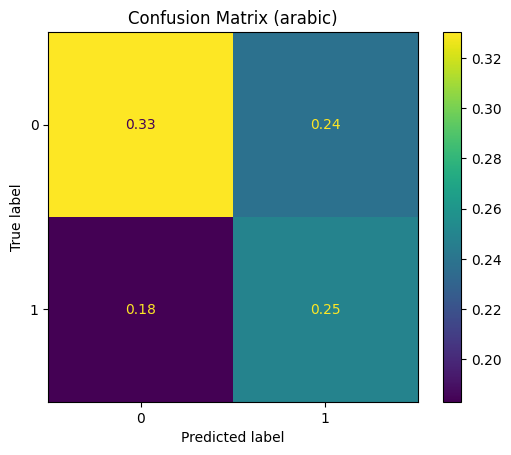

In [17]:
results[language] = detector.test_model(model, test_dl, title=language)

# mDeBERTta v3 base (Bulgarian)

In [18]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5210

In [19]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 250/250 [00:00<00:00, 2388.97it/s]


In [21]:
model = detector.train_model(
    model=model, 
    model_name=f"mDeBERTa-base-subjectivity-{language}.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


Epoch 1/6	Train Loss: 0.695758	Val Loss: 0.695887	L.rate: 0.000003	Val F1: 0.3579
Saving model with new val loss: 0.6958871304988861


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


Epoch 2/6	Train Loss: 0.695504	Val Loss: 0.688193	L.rate: 0.000007	Val F1: 0.5603
Saving model with new val loss: 0.6881929755210876


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 3/6	Train Loss: 0.655116	Val Loss: 0.578913	L.rate: 0.000010	Val F1: 0.7073
Saving model with new val loss: 0.5789125084877014


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 4/6	Train Loss: 0.530839	Val Loss: 0.517317	L.rate: 0.000007	Val F1: 0.7939
Saving model with new val loss: 0.5173171401023865


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]


Epoch 5/6	Train Loss: 0.396822	Val Loss: 0.515188	L.rate: 0.000003	Val F1: 0.7869
Saving model with new val loss: 0.5151881039142608


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]


Epoch 6/6	Train Loss: 0.339068	Val Loss: 0.515556	L.rate: 0.000000	Val F1: 0.8020
Loading the best model checkpoint


Predicting: 100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


{'macro_F1': 0.7566460794844252, 'macro_P': 0.7696280270779539, 'macro_R': 0.7524998366119862, 'SUBJ_F1': 0.7040816326530611, 'SUBJ_P': 0.7752808988764045, 'SUBJ_R': 0.6448598130841121, 'accuracy': 0.768}


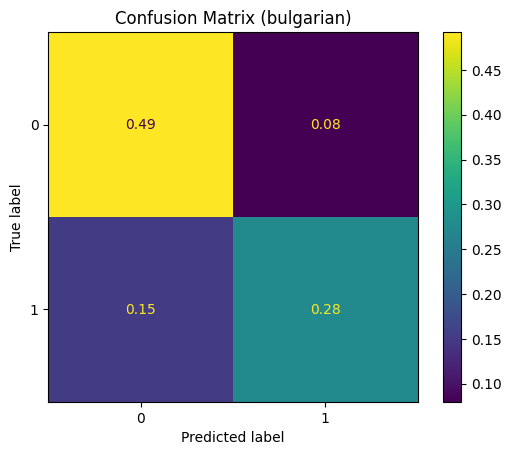

In [22]:
results[language] = detector.test_model(model, test_dl, title=language)

# mDeBERTa-base (English)

In [23]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5352

In [24]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 484/484 [00:00<00:00, 2368.72it/s]


In [26]:
model = detector.train_model(
    model=model, 
    model_name=f"mDeBERTa-base-subjectivity-{language}.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


Epoch 1/6	Train Loss: 0.699021	Val Loss: 0.731729	L.rate: 0.000003	Val F1: 0.3246
Saving model with new val loss: 0.7317288682378572


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.64it/s]


Epoch 2/6	Train Loss: 0.691633	Val Loss: 0.670372	L.rate: 0.000007	Val F1: 0.6827
Saving model with new val loss: 0.6703718345740746


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


Epoch 3/6	Train Loss: 0.594261	Val Loss: 0.503378	L.rate: 0.000010	Val F1: 0.7705
Saving model with new val loss: 0.5033775465241794


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


Epoch 4/6	Train Loss: 0.512742	Val Loss: 0.588985	L.rate: 0.000007	Val F1: 0.6646


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


Epoch 5/6	Train Loss: 0.418901	Val Loss: 0.483955	L.rate: 0.000003	Val F1: 0.7790
Saving model with new val loss: 0.48395452828242863


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.64it/s]


Epoch 6/6	Train Loss: 0.355446	Val Loss: 0.509635	L.rate: 0.000000	Val F1: 0.7652
Loading the best model checkpoint


Predicting: 100%|██████████| 31/31 [00:05<00:00,  6.13it/s]


{'macro_F1': 0.720629295532646, 'macro_P': 0.7952380952380953, 'macro_R': 0.6937324517706729, 'SUBJ_F1': 0.5520833333333333, 'SUBJ_P': 0.7571428571428571, 'SUBJ_R': 0.4344262295081967, 'accuracy': 0.8223140495867769}


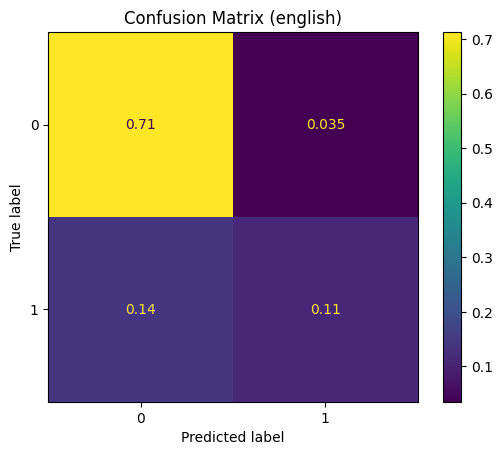

In [27]:
results[language] = detector.test_model(model, test_dl, title=language)

# mDeBERTta v3 base (German)

In [28]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5259

In [29]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 337/337 [00:00<00:00, 2845.39it/s]


In [32]:
model = detector.train_model(
    model=model, 
    model_name=f"mDeBERTa-base-subjectivity-{language}.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.66it/s]


Epoch 1/6	Train Loss: 0.704146	Val Loss: 0.697355	L.rate: 0.000003	Val F1: 0.3923
Saving model with new val loss: 0.6973550761899641


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.64it/s]


Epoch 2/6	Train Loss: 0.701056	Val Loss: 0.691133	L.rate: 0.000007	Val F1: 0.3923
Saving model with new val loss: 0.6911332664951202


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


Epoch 3/6	Train Loss: 0.632122	Val Loss: 0.565185	L.rate: 0.000010	Val F1: 0.7585
Saving model with new val loss: 0.5651851248356604


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


Epoch 4/6	Train Loss: 0.487244	Val Loss: 0.595015	L.rate: 0.000007	Val F1: 0.7540


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


Epoch 5/6	Train Loss: 0.401776	Val Loss: 0.583514	L.rate: 0.000003	Val F1: 0.7720


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.65it/s]


Epoch 6/6	Train Loss: 0.338691	Val Loss: 0.600008	L.rate: 0.000000	Val F1: 0.7726
Loading the best model checkpoint


Predicting: 100%|██████████| 22/22 [00:03<00:00,  6.20it/s]

{'macro_F1': 0.7965283018867924, 'macro_P': 0.7890778286461739, 'macro_R': 0.8171490074144941, 'SUBJ_F1': 0.7439999999999999, 'SUBJ_P': 0.6690647482014388, 'SUBJ_R': 0.8378378378378378, 'accuracy': 0.8100890207715133}


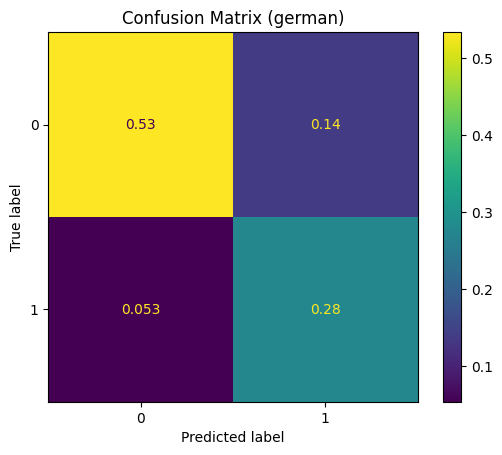

In [33]:
results[language] = detector.test_model(model, test_dl, title=language)

# mDeBERTa-base (italian)

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5075

In [35]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.all_data[language]['train']['sentence'], detector.all_data[language]['train']['label']
X_dev, y_dev = detector.all_data[language]['dev']['sentence'], detector.all_data[language]['dev']['label']
X_test, y_test = detector.all_data[language]['test']['sentence'], detector.all_data[language]['test']['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 513/513 [00:00<00:00, 2215.18it/s]


In [37]:
model = detector.train_model(
    model=model, 
    model_name=f"mDeBERTa-base-subjectivity-{language}.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 1/6	Train Loss: 0.694592	Val Loss: 0.691375	L.rate: 0.000003	Val F1: 0.2179
Saving model with new val loss: 0.6913746212209974


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 2/6	Train Loss: 0.684670	Val Loss: 0.645102	L.rate: 0.000007	Val F1: 0.4962
Saving model with new val loss: 0.6451016423248109


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 3/6	Train Loss: 0.531481	Val Loss: 0.507617	L.rate: 0.000010	Val F1: 0.7185
Saving model with new val loss: 0.5076166338154248


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 4/6	Train Loss: 0.345665	Val Loss: 0.663301	L.rate: 0.000007	Val F1: 0.7313


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.79it/s]


Epoch 5/6	Train Loss: 0.206587	Val Loss: 0.801473	L.rate: 0.000003	Val F1: 0.7330


Evaluating: 100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch 6/6	Train Loss: 0.151441	Val Loss: 0.875662	L.rate: 0.000000	Val F1: 0.7207
Loading the best model checkpoint


Predicting: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]


{'macro_F1': 0.7682627774909654, 'macro_P': 0.7573599240265907, 'macro_R': 0.7854189421126541, 'SUBJ_F1': 0.6711409395973154, 'SUBJ_P': 0.6172839506172839, 'SUBJ_R': 0.7352941176470589, 'accuracy': 0.8089668615984406}


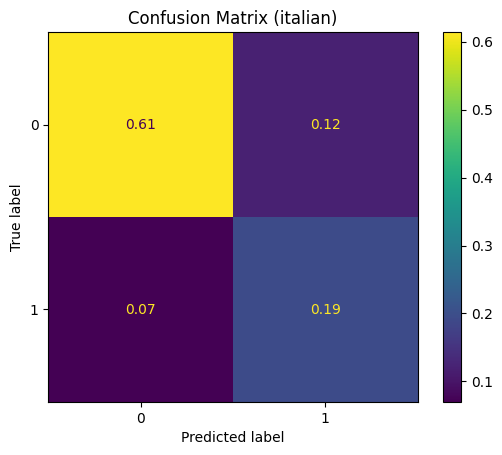

In [38]:
results[language] = detector.test_model(model, test_dl, title=language)

# mDeBERTa-base (multilingual)

In [39]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5222

In [40]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = detector.get_model(
    model_card=model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

# Get the data
X_train, y_train = detector.train['sentence'], detector.train['label']
X_dev, y_dev = detector.dev['sentence'], detector.dev['label']
X_test, y_test = detector.test['sentence'], detector.test['label']

# Convert y to tensor
y_train = torch.tensor(y_train.values)
y_dev = torch.tensor(y_dev.values)
y_test = torch.tensor(y_test.values)

# Tokenize the text
train_input_ids, train_attention_masks = detector.tokenize_text(X_train)
dev_input_ids, dev_attention_masks = detector.tokenize_text(X_dev)
test_input_ids, test_attention_masks = detector.tokenize_text(X_test)

# Create dataloaders
train_dl = detector.create_dataloader(train_input_ids, train_attention_masks, y_train, batch_size=batch_size, shuffle=True, pin_mem=True)
dev_dl = detector.create_dataloader(dev_input_ids, dev_attention_masks, y_dev, batch_size=batch_size, shuffle=False, pin_mem=True)
test_dl = detector.create_dataloader(test_input_ids, test_attention_masks, y_test, batch_size=batch_size, shuffle=False, pin_mem=False)

class_weights = detector.get_class_weights(detector.train)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = len(train_dl) * epochs
n_warmup_steps = total_steps // 2 # half of the epoch as warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

Tokenize of sentences: 100%|██████████| 2332/2332 [00:01<00:00, 2061.30it/s]


In [42]:
model = detector.train_model(
    model=model, 
    model_name="mDeBERTa-base-subjectivity-multi.pth", 
    train_dl=train_dl, 
    dev_dl=dev_dl, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=epochs, 
    device=device)

Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 1/6	Train Loss: 0.693122	Val Loss: 0.676968	L.rate: 0.000003	Val F1: 0.4935
Saving model with new val loss: 0.6769676263758678


Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 2/6	Train Loss: 0.590837	Val Loss: 0.522367	L.rate: 0.000007	Val F1: 0.6989
Saving model with new val loss: 0.5223669672249168


Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 3/6	Train Loss: 0.505272	Val Loss: 0.553011	L.rate: 0.000010	Val F1: 0.7099


Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 4/6	Train Loss: 0.440144	Val Loss: 0.608222	L.rate: 0.000007	Val F1: 0.7430


Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 5/6	Train Loss: 0.367234	Val Loss: 0.800676	L.rate: 0.000003	Val F1: 0.7541


Evaluating: 100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Epoch 6/6	Train Loss: 0.321973	Val Loss: 0.814157	L.rate: 0.000000	Val F1: 0.7504
Loading the best model checkpoint


Predicting: 100%|██████████| 146/146 [00:24<00:00,  5.98it/s]


{'macro_F1': 0.6829632044333971, 'macro_P': 0.7125233378036732, 'macro_R': 0.730937318092495, 'SUBJ_F1': 0.6560449859418931, 'SUBJ_P': 0.5243445692883895, 'SUBJ_R': 0.8760951188986232, 'accuracy': 0.6852487135506004}


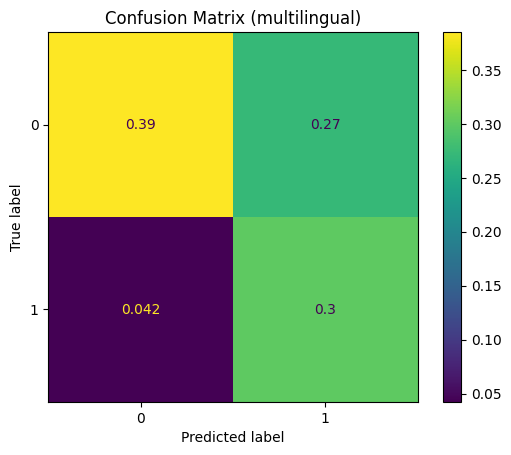

In [43]:
results['multi'] = detector.test_model(model, test_dl, title='multilingual')

In [45]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german,0.796528,0.789078,0.817149,0.744000,0.669065,0.837838,0.810089
italian,0.768263,0.757360,0.785419,0.671141,0.617284,0.735294,0.808967
bulgarian,0.756646,0.769628,0.752500,0.704082,0.775281,0.644860,0.768000
english,0.720629,0.795238,0.693732,0.552083,0.757143,0.434426,0.822314
multi,0.682963,0.712523,0.730937,0.656045,0.524345,0.876095,0.685249
arabic,0.576058,0.577109,0.578514,0.541485,0.510989,0.575851,0.578877
